In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def bs_price_greeks(S0, K, T, r, sigma, option_type='call', q=0.0):
    """

    S0 : float
        Current stock price.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free interest rate (continuous).
    sigma : float
        Volatility (annualized).
    option_type : str
        'call' or 'put'.
    q : float
        Dividend yield (annualized, continuous).

    """
    if T <= 0 or sigma <= 0:
        raise ValueError("T and sigma must be positive for Black-Scholes.")

    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nmd1 = norm.cdf(-d1)
    Nmd2 = norm.cdf(-d2)

    pdf_d1 = norm.pdf(d1)

    disc_r = np.exp(-r * T)
    disc_q = np.exp(-q * T)

    if option_type == 'call':
        price = S0 * disc_q * Nd1 - K * disc_r * Nd2
        delta = disc_q * Nd1
        theta = (- (S0 * disc_q * pdf_d1 * sigma) / (2 * sqrtT)
                 + q * S0 * disc_q * Nd1
                 - r * K * disc_r * Nd2)
    elif option_type == 'put':
        price = K * disc_r * Nmd2 - S0 * disc_q * Nmd1
        delta = disc_q * (Nd1 - 1)
        theta = (- (S0 * disc_q * pdf_d1 * sigma) / (2 * sqrtT)
                 - q * S0 * disc_q * Nmd1
                 + r * K * disc_r * Nmd2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    gamma = (disc_q * pdf_d1) / (S0 * sigma * sqrtT)
    vega = S0 * disc_q * pdf_d1 * sqrtT

    return price, delta, gamma, theta, vega


In [12]:
S0    = 440.0   
K     = 440.0   
T     = 72/252    
r     = 0.0375 
q     = 0.0     
sigma = 0.5179  
N=66


In [13]:
bs_call = bs_price_greeks(S0, K, T, r, sigma, option_type='call', q=q)
bs_put  = bs_price_greeks(S0, K, T, r, sigma, option_type='put',  q=q)

print("BS European Call:")
print(f"  Price = {bs_call[0]:.4f}")
print(f"  Delta = {bs_call[1]:.4f}")
print(f"  Gamma = {bs_call[2]:.6f}")
print(f"  Theta = {bs_call[3]:.4f}  (per year)")
print(f"  Vega  = {bs_call[4]:.4f}")

print("\nBS European Put:")
print(f"  Price = {bs_put[0]:.4f}")
print(f"  Delta = {bs_put[1]:.4f}")
print(f"  Gamma = {bs_put[2]:.6f}")
print(f"  Theta = {bs_put[3]:.4f}  (per year)")
print(f"  Vega  = {bs_put[4]:.4f}")


BS European Call:
  Price = 50.5607
  Delta = 0.5703
  Gamma = 0.003224
  Theta = -91.2283  (per year)
  Vega  = 92.3670

BS European Put:
  Price = 45.8716
  Delta = -0.4297
  Gamma = 0.003224
  Theta = -74.9041  (per year)
  Vega  = 92.3670


In [14]:
def binomial_european_crr(S0, K, T, r, sigma, N, option_type='call', q=0.0):
    """
 
    S0 : float
        Current stock price.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free interest rate (continuously compounded).
    sigma : float
        Volatility (annualized).
    N : int
        Number of time steps.
    option_type : str
        'call' or 'put'.
    q : float
        Dividend yield (annualized, continuous)

    """
    dt = T / N
  
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u

   
    disc = np.exp(-r * dt)
    p = (np.exp((r - q) * dt) - d) / (u - d)

    if p < 0 or p > 1:
        raise ValueError(f"Risk-neutral probability out of bounds: p={p:.4f}. "
                         "Check r, sigma, dt, or N.")

   
    j = np.arange(N + 1)
    ST = S0 * (u ** j) * (d ** (N - j))

  
    if option_type == 'call':
        V = np.maximum(ST - K, 0.0)
    elif option_type == 'put':
        V = np.maximum(K - ST, 0.0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

 
    for i in range(N - 1, -1, -1):
        V = disc * (p * V[1:i+2] + (1 - p) * V[0:i+1])

    price = V[0]
    return price


In [15]:
call_price = binomial_european_crr(S0, K, T, r, sigma, N, option_type='call', q=0.0)
print(call_price)

50.37841430887752


In [16]:
N = 1000

bin_call = binomial_european_crr(S0, K, T, r, sigma, N,
                               option_type='call',
                               q=q)

bin_put = binomial_european_crr(S0, K, T, r, sigma, N,
                              option_type='put',
                              q=q)

print(f"\nBinomial European Call (N={N}): {bin_call:.4f}")
print(f"Black-Scholes Call:              {bs_call[0]:.4f}")

print(f"\nBinomial European Put (N={N}):  {bin_put:.4f}")
print(f"Black-Scholes Put:              {bs_put[0]:.4f}")



Binomial European Call (N=1000): 50.5486
Black-Scholes Call:              50.5607

Binomial European Put (N=1000):  45.8595
Black-Scholes Put:              45.8716


In [19]:

bs_call = bs_price_greeks(S0, K, T, r, sigma, option_type='call', q=q)
bs_call_price = bs_call[0]   

bin_prices = []
errors = []
Ns = [5, 10, 20, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000]
for N in Ns:
    price_N = float(binomial_european_crr(S0, K, T, r, sigma, N,
                                          option_type='call',
                                          q=q))
    bin_prices.append(price_N)
    errors.append(price_N - bs_call_price) 


In [20]:
print("\nConvergence of Binomial European Call to Black-Scholes:")
print("   N    Binomial Price    Error (Bin - BS)")
for N, p, e in zip(Ns, bin_prices, errors):
    print(f"{N:4d}   {p:14.4f}   {e: .6f}")


Convergence of Binomial European Call to Black-Scholes:
   N    Binomial Price    Error (Bin - BS)
   5          52.9769    2.416216
  10          49.3722   -1.188472
  20          49.9620   -0.598677
  50          50.3202   -0.240452
  75          50.7191    0.158454
 100          50.4403   -0.120382
 150          50.4804   -0.080289
 200          50.5005   -0.060230
 300          50.5205   -0.040162
 400          50.5306   -0.030124
 500          50.5366   -0.024101
 750          50.5446   -0.016069
1000          50.5486   -0.012052


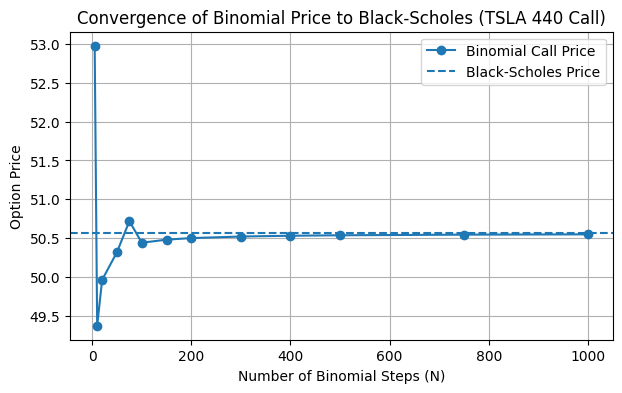

In [21]:
plt.figure(figsize=(7, 4))
plt.plot(Ns, bin_prices, marker='o', label='Binomial Call Price')
plt.axhline(bs_call_price, linestyle='--', label='Black-Scholes Price')
plt.xlabel("Number of Binomial Steps (N)")
plt.ylabel("Option Price")
plt.title("Convergence of Binomial Price to Black-Scholes (TSLA 440 Call)")
plt.legend()
plt.grid(True)
plt.show()


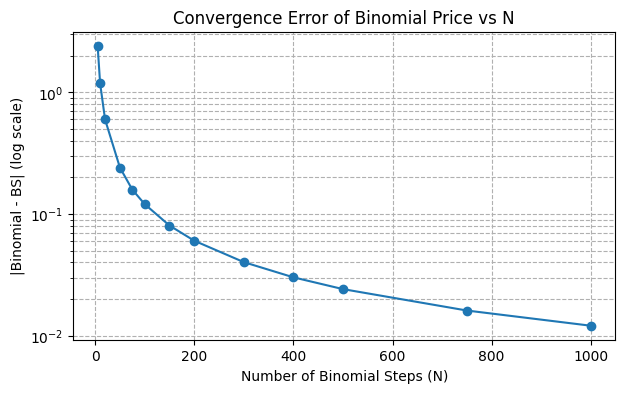

In [22]:
abs_errors = np.abs(np.array(errors))

plt.figure(figsize=(7, 4))
plt.plot(Ns, abs_errors, marker='o')
plt.yscale('log')
plt.xlabel("Number of Binomial Steps (N)")
plt.ylabel("|Binomial - BS| (log scale)")
plt.title("Convergence Error of Binomial Price vs N")
plt.grid(True, which="both", ls="--")
plt.show()


## Black–Scholes Greeks for TSLA ATM Call


In [27]:
bs_call_price, bs_delta, bs_gamma, bs_theta, bs_vega = bs_price_greeks(
    S0, K, T, r, sigma, option_type='call', q=q
)

print(f"Price : {bs_call_price:.4f}")
print(f"Delta : {bs_delta:.4f}")
print(f"Gamma : {bs_gamma:.6f}")
print(f"Theta : {bs_theta:.4f} (per year)")
print(f"Vega  : {bs_vega:.4f}")


Price : 50.5607
Delta : 0.5703
Gamma : 0.003224
Theta : -91.2283 (per year)
Vega  : 92.3670


In [28]:
S_grid = np.linspace(0.7*S0, 1.3*S0, 40)

prices, deltas, gammas, thetas, vegas = [], [], [], [], []

for S in S_grid:
    p, d, g, t, v = bs_price_greeks(S, K, T, r, sigma, option_type='call', q=q)
    prices.append(p)
    deltas.append(d)
    gammas.append(g)
    thetas.append(t)
    vegas.append(v)


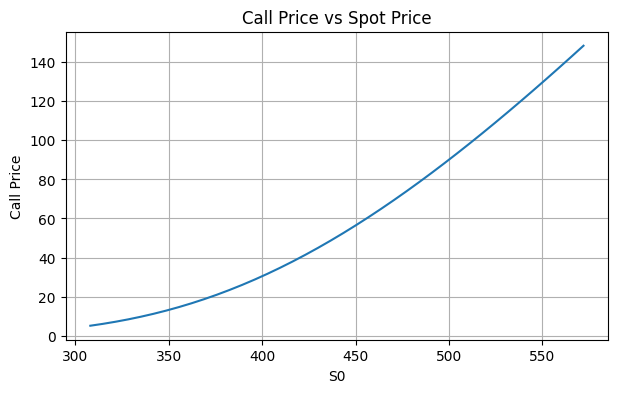

In [29]:
plt.figure(figsize=(7,4))
plt.plot(S_grid, prices)
plt.xlabel("S0")
plt.ylabel("Call Price")
plt.title("Call Price vs Spot Price")
plt.grid(True)
plt.show()


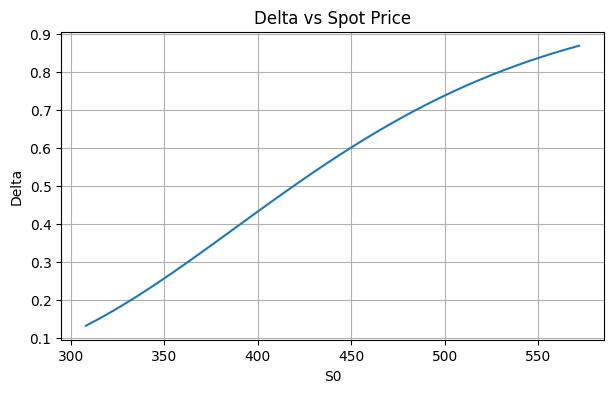

In [30]:
plt.figure(figsize=(7,4))
plt.plot(S_grid, deltas)
plt.xlabel("S0")
plt.ylabel("Delta")
plt.title("Delta vs Spot Price")
plt.grid(True)
plt.show()


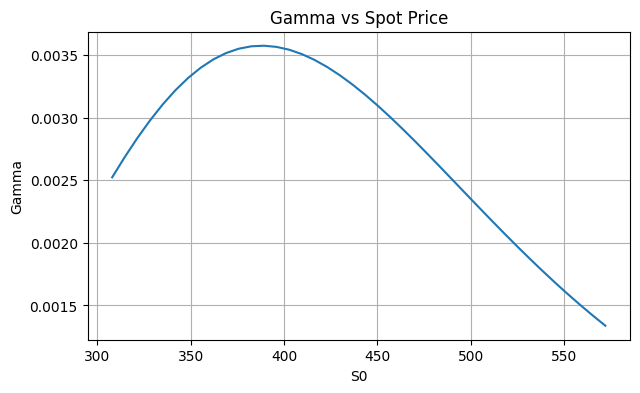

In [31]:
plt.figure(figsize=(7,4))
plt.plot(S_grid, gammas)
plt.xlabel("S0")
plt.ylabel("Gamma")
plt.title("Gamma vs Spot Price")
plt.grid(True)
plt.show()


In [32]:
sigma_grid = np.linspace(0.2, 1.0, 40)

prices, vegas = [], []

for sig in sigma_grid:
    p, _, _, _, v = bs_price_greeks(S0, K, T, r, sig, option_type='call', q=q)
    prices.append(p)
    vegas.append(v)


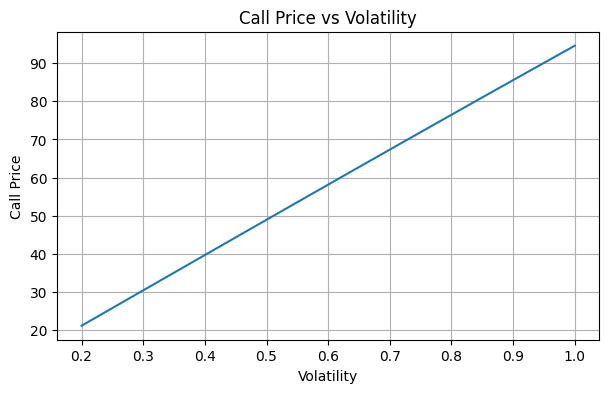

In [33]:
plt.figure(figsize=(7,4))
plt.plot(sigma_grid, prices)
plt.xlabel("Volatility")
plt.ylabel("Call Price")
plt.title("Call Price vs Volatility")
plt.grid(True)
plt.show()


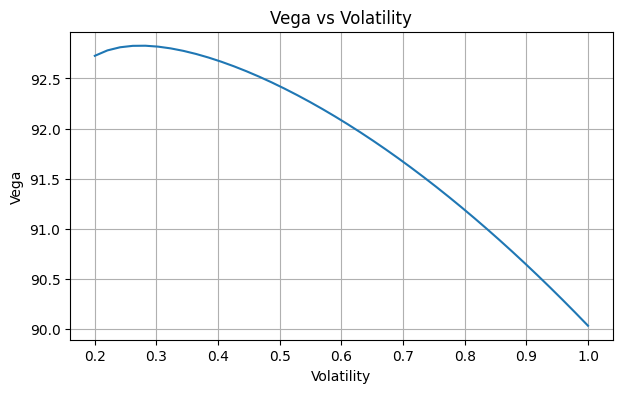

In [34]:
plt.figure(figsize=(7,4))
plt.plot(sigma_grid, vegas)
plt.xlabel("Volatility")
plt.ylabel("Vega")
plt.title("Vega vs Volatility")
plt.grid(True)
plt.show()


In [36]:
T_grid = np.linspace(10/252, 200/252, 40)

prices_T = []
thetas_T = []
vegas_T  = []

for T_ in T_grid:
    price, _, _, theta, vega = bs_price_greeks(
        S0, K, T_, r, sigma, option_type='call', q=q
    )
    prices_T.append(price)
    thetas_T.append(theta)
    vegas_T.append(vega)


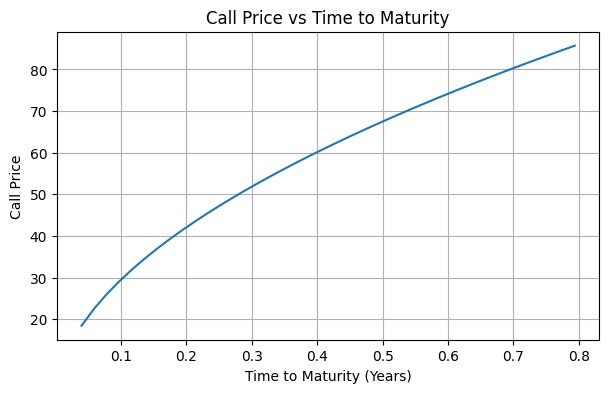

In [37]:
plt.figure(figsize=(7,4))
plt.plot(T_grid, prices_T)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Call Price")
plt.title("Call Price vs Time to Maturity")
plt.grid(True)
plt.show()


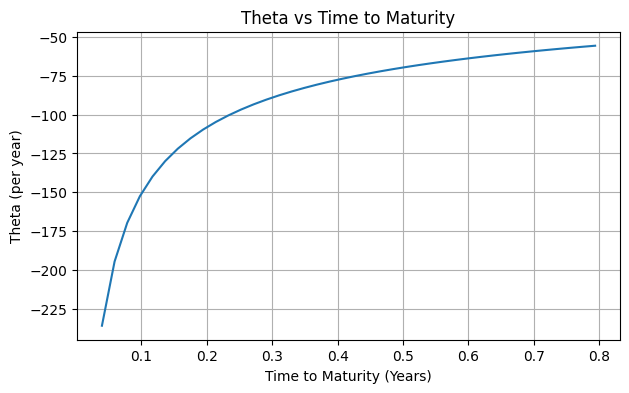

In [38]:
plt.figure(figsize=(7,4))
plt.plot(T_grid, thetas_T)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Theta (per year)")
plt.title("Theta vs Time to Maturity")
plt.grid(True)
plt.show()


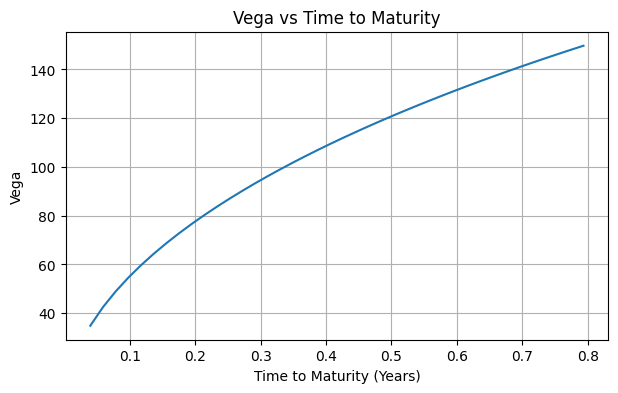

In [39]:
plt.figure(figsize=(7,4))
plt.plot(T_grid, vegas_T)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Vega")
plt.title("Vega vs Time to Maturity")
plt.grid(True)
plt.show()


In [40]:
r_grid = np.linspace(0.0, 0.10, 40)

prices_r = []

for r_ in r_grid:
    price, _, _, _, _ = bs_price_greeks(
        S0, K, T, r_, sigma, option_type='call', q=q
    )
    prices_r.append(price)


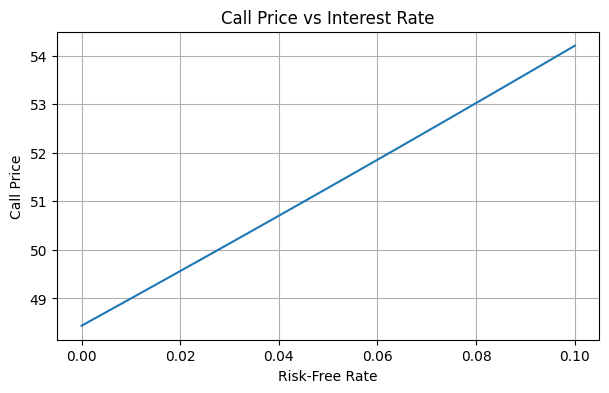

In [41]:
plt.figure(figsize=(7,4))
plt.plot(r_grid, prices_r)
plt.xlabel("Risk-Free Rate")
plt.ylabel("Call Price")
plt.title("Call Price vs Interest Rate")
plt.grid(True)
plt.show()
